# 1D Metropolis–Hastings with theano and tensorflow
A small benchmark on speed etc, also an idea to use control flow to get full MH trace.

In [1]:
%pylab inline
import numpy as np
import pymc3 as pm

import theano.tensor as tt
import theano

pm.__version__

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'3.4.1'

Record in the PyMC3 doc: [How PyMC3 uses Theano](http://docs.pymc.io/theano.html#how-pymc3-uses-theano), the most important side effect of a model construction is the model log-likelihood function and its gradient: it is the non-normalized posterior distribution, proportional to likelihood times prior.

In [2]:
data = 10.
# prior for mu and sd
prior = [0., 100.]

In [3]:
theano.config.compute_test_value='off'
mu_th = tt.scalar('mu')
logp_th = pm.Normal.dist(mu=prior[0], sd=prior[1]).logp(mu_th)
logp_th += pm.Normal.dist(mu_th, 1.).logp(data)

In [4]:
logp_th.eval({mu_th: 0.})

array(-56.44304725)

Similarly, we can set up the logp in tensorflow as below:

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

tf.__version__

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frame

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, 

'1.9.0-dev20180503'

In [6]:
mu0 = tf.Variable(0., tf.float64)

In [7]:
mu_tf = tfd.Normal(loc=prior[0], scale=prior[1])

In [8]:
mu_tf.log_prob(mu0)

<tf.Tensor 'Normal/log_prob/sub:0' shape=() dtype=float32>

In [9]:
y_tf = tfd.Normal(loc=mu0, scale=1.)
logp_tf = y_tf.log_prob(data) + mu_tf.log_prob(mu0)

In [10]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
print(sess.run(logp_tf))

-56.443047


Metropolis–Hastings algorithm, with kernel and control flow in numpy:

In [11]:
scale = 1.
nsample = 10000

Tensorflow version:

In [12]:
%%time
trace = dict(mu=np.zeros(nsample),
             logp=np.zeros(nsample),
             accept=np.zeros(nsample))

# logp0 = sess.run(logp_tf, feed_dict={mu0: 0.})
with sess.as_default():
    logp0 = logp_tf.eval({mu0: 0.})

trace['mu'][0] = 0.
trace['logp'][0] = logp0
trace['accept'][0] = 1

for s in range(1, nsample):
    mu_ = trace['mu'][s-1]
    logp_ = trace['logp'][s-1]
    mu_p = mu_ + np.random.randn()*scale

    # evaluation of logp
    logp_p = sess.run(logp_tf, feed_dict={mu0: mu_p})
#     with sess.as_default():
#         logp_p = logp_tf.eval({mu0: mu_p})

    if np.log(np.random.rand()) < logp_p-logp_:
        trace['mu'][s] = mu_p
        trace['logp'][s] = logp_p
        trace['accept'][s] = 1
    else:
        trace['mu'][s] = mu_
        trace['logp'][s] = logp_
        trace['accept'][s] = 0

CPU times: user 4.12 s, sys: 460 ms, total: 4.58 s
Wall time: 4.02 s


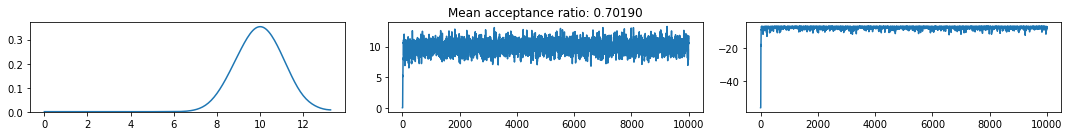

In [13]:
trace_tf = trace
_, ax = plt.subplots(1, 3, figsize=(15, 2))
pm.kdeplot(trace['mu'], ax=ax[0])
ax[1].plot(trace['mu'])
ax[1].set_title('Mean acceptance ratio: {:.5f}'
                .format(trace['accept'].mean()))
ax[2].plot(trace['logp'])
plt.tight_layout();

Theano version:

In [14]:
%%time
trace = dict(mu=np.zeros(nsample),
             logp=np.zeros(nsample),
             accept=np.zeros(nsample))

logp0 = logp_th.eval({mu_th: 0.})
  
trace['mu'][0] = 0.
trace['logp'][0] = logp0
trace['accept'][0] = 1

for s in range(1, nsample):
    mu_ = trace['mu'][s-1]
    logp_ = trace['logp'][s-1]
    mu_p = mu_ + np.random.randn()*scale

    # evaluation of logp
    logp_p = logp_th.eval({mu_th: mu_p})

    if np.log(np.random.rand()) < logp_p-logp_:
        trace['mu'][s] = mu_p
        trace['logp'][s] = logp_p
        trace['accept'][s] = 1
    else:
        trace['mu'][s] = mu_
        trace['logp'][s] = logp_
        trace['accept'][s] = 0

CPU times: user 605 ms, sys: 8.99 ms, total: 614 ms
Wall time: 656 ms


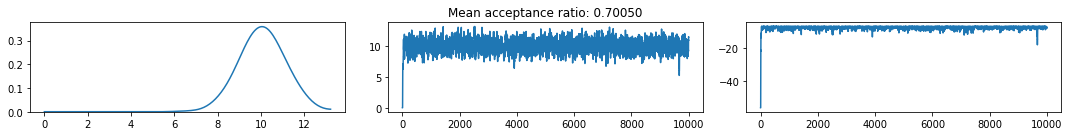

In [15]:
trace_th = trace
_, ax = plt.subplots(1, 3, figsize=(15, 2))
pm.kdeplot(trace['mu'], ax=ax[0])
ax[1].plot(trace['mu'])
ax[1].set_title('Mean acceptance ratio: {:.5f}'
                .format(trace['accept'].mean()))
ax[2].plot(trace['logp'])
plt.tight_layout();

As you can see from the timing above, the sampling is way faster in theano. Basically, if we are going to do everything in an imperative programming style, the speed comes down to how fast you can evaluate logp (and dlogp in gradient based method).

~~Using the MH from tensorflow is pretty fast, however, it is not quite what we used to as it does not output the whole chain, instead it ouputs the final state. In a way you can use it as if it output a chain (or a particle filter / SMC). For example, specifying the number of chain = nsample we can treat the final output as samples from the posterior.~~

The key of getting good performance using tensorflow is to save all the result in the graph, and then fetch the value back to python once sampling is done:  
MH sampling with a random walk kernel, in tensorflow/probability

In [16]:
from tensorflow_probability.python.mcmc.random_walk_metropolis import random_walk_normal_fn
from tensorflow_probability import edward2 as ed

In [17]:
dtype = np.float32
def target_log_prob(x):
    latent = tfd.Normal(loc=dtype(0), scale=dtype(100))
    y = tfd.Normal(loc=x, scale=dtype(1))
    return latent.log_prob(x)+y.log_prob(data)

samples, _ = tfp.mcmc.sample_chain(
    num_results=1000,
    current_state=dtype(1),
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob,
        seed=42),
    num_burnin_steps=500,
    parallel_iterations=1)  # For determinism.
sample_mean = tf.reduce_mean(samples, axis=0)
sample_std = tf.sqrt(
    tf.reduce_mean(tf.squared_difference(samples, sample_mean),
                   axis=0))
with tf.Session() as sess:
    [sample_mean_, sample_std_] = sess.run([sample_mean, sample_std])

print('Estimated mean: {}'.format(sample_mean_))
print('Estimated standard deviation: {}'.format(sample_std_))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, 

Estimated mean: 9.791464805603027
Estimated standard deviation: 0.9650713205337524


In [18]:
tf.reset_default_graph()

def Normal_model():
    x = ed.Normal(loc=0., scale=100., name='x')
    y = ed.Normal(loc=x, scale=1., name='y')
    return y

model_template = tf.make_template('Normal_model', Normal_model)
log_joint = ed.make_log_joint_fn(model_template)

def target_log_prob_fn(x):
    """Unnormalized target density as a function of states."""
    return log_joint(x=x, y=data)

In [19]:
%%time
trace = dict(mu=np.zeros(nsample),
             logp=np.zeros(nsample),
             accept=np.zeros(nsample))

samples, kernelresult = tfp.mcmc.sample_chain(
    num_results=nsample,
    current_state=tf.zeros([], name='x'),
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn,
        seed=42),
    num_burnin_steps=0,
    parallel_iterations=1)  # For determinism.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow_probability/python/edward2/program_transformations.py:132: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  argspec = inspect.getargspec(f._func)  # pylint: disable=protected-access
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow_probability/python/edward2/program_transformation

CPU times: user 469 ms, sys: 13.2 ms, total: 482 ms
Wall time: 528 ms


Sampling is fairly fast, but fetching the result from the graph still takes some time

In [20]:
with tf.Session() as sess:
    [
        trace['mu'],
        trace['logp'],
        trace['accept']
    ] = sess.run(
        [samples,
         target_log_prob(samples),
         kernelresult.is_accepted
         ])

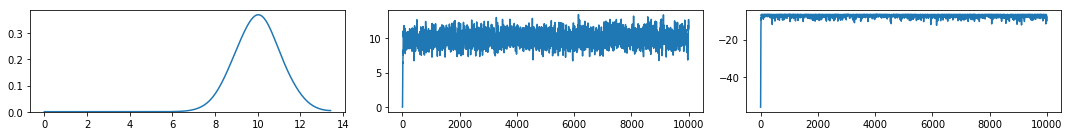

In [21]:
trace_tf1 = trace
_, ax = plt.subplots(1, 3, figsize=(15, 2))
pm.kdeplot(trace['mu'], ax=ax[0])
ax[1].plot(trace['mu'])
ax[2].plot(trace['logp'])
plt.tight_layout();

In [22]:
kernel=tfp.mcmc.RandomWalkMetropolis(
       target_log_prob,
       seed=42)

In [23]:
state = tf.zeros([], name='x')
previous_kernel_results = kernel.bootstrap_results(state)

In [24]:
kernel.one_step(state, previous_kernel_results)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


(<tf.Tensor 'mh_one_step/choose_next_state/Select:0' shape=() dtype=float32>,
 MetropolisHastingsKernelResults(accepted_results=UncalibratedRandomWalkResults(log_acceptance_correction=<tf.Tensor 'mh_one_step/choose_inner_results/Select:0' shape=() dtype=float32>, target_log_prob=<tf.Tensor 'mh_one_step/choose_inner_results_1/Select:0' shape=() dtype=float32>), is_accepted=<tf.Tensor 'mh_one_step/Less:0' shape=() dtype=bool>, log_accept_ratio=<tf.Tensor 'mh_one_step/compute_log_accept_ratio/Sum:0' shape=() dtype=float32>, proposed_state=<tf.Tensor 'mh_one_step/rwm_one_step/random_walk_normal_fn/random_normal:0' shape=() dtype=float32>, proposed_results=UncalibratedRandomWalkResults(log_acceptance_correction=<tf.Tensor 'mh_one_step/rwm_one_step/zeros:0' shape=() dtype=float32>, target_log_prob=<tf.Tensor 'mh_one_step/rwm_one_step/add:0' shape=() dtype=float32>)))

In [25]:
%%time
ndim = 100
nstep = 10000

tf.reset_default_graph()
i0 = tf.constant(0)
m0 = tf.ones([1, ndim])
walk = tf.random_normal([1, ndim], mean=0., stddev=1.)
c = lambda i, m: i < nstep
b = lambda i, m: [i+1, 
                  tf.concat([m, m[-1]+tf.random_normal([1, ndim], mean=0., stddev=1.)], 
                            axis=0)]
r = tf.while_loop(
    c, b, loop_vars=[i0, m0],
    shape_invariants=[i0.get_shape(), tf.TensorShape([None, ndim])])

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    r_ = sess.run(r)

CPU times: user 12 s, sys: 8.36 s, total: 20.4 s
Wall time: 17.1 s


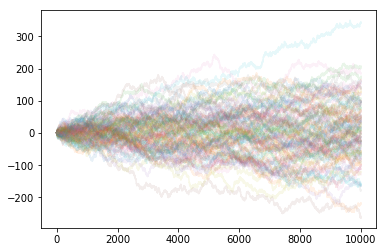

In [26]:
plt.plot(r_[1], alpha=.1);

# Modified based on Bayesflow [OLD CODE]

In [ ]:
tf.reset_default_graph()
# Generate nsample initial values randomly. Each of these would be an
# independent starting point for a Markov chain.
state = variable_scope.get_variable('state', initializer=[0.0])

# Computes the log(p(x))
def log_density(x):
    mu = tfd.Normal(loc=0., scale=100.)
    y = tfd.Normal(loc=x, scale=1.)
    logp2 = y.log_prob(data)+mu.log_prob(x)
    return logp2

# Initial log-density value
state_log_density = tf.get_variable(
    "state_log_density",
    initializer=log_density(state.initialized_value()))

# A variable to store the log_acceptance_ratio:
log_acceptance_ratio = tf.get_variable(
    "log_acceptance_ratio",
    initializer=tf.zeros([1], dtype=tf.float32))

# Generates random proposals
def random_proposal(x):
      return (x + tf.random_normal(tf.shape(x), mean=0., stddev=scale,
                                dtype=x.dtype, seed=12)), None

In [ ]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import control_flow_ops

def mhevolve(initial_sample,
           initial_log_density,
           initial_log_accept_ratio,
           target_log_prob_fn,
           proposal_fn,
           n_steps=1,
           seed=None,
           name=None):
    with ops.name_scope(name, "metropolis_hastings", [initial_sample]):
        current_state = tf.expand_dims(initial_sample, 0)
        current_target_log_prob = tf.expand_dims(initial_log_density, 0)
        log_accept_ratio = initial_log_accept_ratio

        def step(i, current_state, current_target_log_prob, log_accept_ratio):
            """Wrap single Markov chain iteration in `while_loop`."""
            next_state, kernel_results = mh.kernel(
                      target_log_prob_fn=target_log_prob_fn,
                      proposal_fn=proposal_fn,
                      current_state=current_state[-1, :],
                      current_target_log_prob=current_target_log_prob[-1, :],
                      seed=seed)
            accepted_log_prob = kernel_results.current_target_log_prob
            log_accept_ratio = kernel_results.log_accept_ratio
            current_state = tf.concat([current_state, tf.expand_dims(next_state, 0)], 
                            axis=0)
            current_target_log_prob = tf.concat([current_target_log_prob,
                                                 tf.expand_dims(accepted_log_prob, 0)], 
                            axis=0)
            return i + 1, current_state, current_target_log_prob, log_accept_ratio
        
        i0 = tf.constant(0)
        
        (_, accepted_state, accepted_target_log_prob, accepted_log_accept_ratio) = (
            control_flow_ops.while_loop(
                cond=lambda i, *ignored_args: i < n_steps,
                body=step,
                loop_vars=[
                    i0,  # i
                    current_state,
                    current_target_log_prob,
                    log_accept_ratio,
                ],
                # the magic here
                shape_invariants=[
                    i0.get_shape(),
                    tf.TensorShape([None, 1]),
                    tf.TensorShape([None, 1]),
                    log_accept_ratio.get_shape(),
                ],
                parallel_iterations=1 if seed is not None else 10,
                # TODO(b/73775595): Confirm optimal setting of swap_memory.
                swap_memory=1))

        forward_step = control_flow_ops.group(
            accepted_target_log_prob,
            accepted_state,
            accepted_log_accept_ratio
        )

    return accepted_state, accepted_target_log_prob, accepted_log_accept_ratio

In [ ]:
%%time
#  Create the op to propagate the chain for 100 steps.
accepted_state, accepted_target_log_prob, accepted_log_accept_ratio = mhevolve(
    state, state_log_density, log_acceptance_ratio,
    log_density, random_proposal, n_steps=nsample, seed=123)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    # Run the chains for a total of 1000 steps
    # Executing the stepper advances the chain to the next state.
    samples, alog_prob, a_ratio = sess.run(
        [accepted_state, accepted_target_log_prob, accepted_log_accept_ratio])

In [ ]:
trace = dict(mu=np.zeros(nsample),
             logp=np.zeros(nsample),
             accept=np.zeros(nsample))

trace['mu'] = samples[1:].squeeze()
trace['logp'] = alog_prob[1:].squeeze()
trace['accept'][1:] = trace['mu'][1:] != trace['mu'][:-1]

In [ ]:
trace_tf3 = trace
_, ax = plt.subplots(1, 3, figsize=(15, 2))
pm.kdeplot(trace['mu'], ax=ax[0])
ax[1].plot(trace['mu'])
ax[1].set_title('Mean acceptance ratio: {:.5f}'
                .format(trace['accept'].mean()))
ax[2].plot(trace['logp'])
plt.tight_layout();